## **Test 1**

In [ ]:
#install all the required dependancy libraries
!pip install tensorflow #for prediction
!pip install numpy  #for matrix multiplication
!pip install pandas #define the data structures
!pip install matplotlib #for visualization
!pip install scikit-learn #for normalizing our data(scaling)

#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

     |████████████████████████████████| 462 kB 5.0 MB/s 


In [ ]:
btc = pd.read_csv(('btc.csv'))
btc.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,Mar-04-2022,39144.653088,39576.600600,38750.396893,39409.212469,5.940748e+10,7.427309e+11
1,Mar-03-2022,42465.006625,42498.516261,38732.824915,39120.042399,7.318878e+10,7.768194e+11
2,Mar-02-2022,43901.746144,44035.459040,41862.518100,42450.883432,6.651299e+10,8.180203e+11
3,Mar-01-2022,44404.917900,45173.580898,43387.876900,43938.476843,7.774557e+10,8.356338e+11
4,Feb-28-2022,43182.005400,44788.074900,42934.442600,44359.871200,9.293590e+10,8.277103e+11


In [ ]:
#selecting only the column that we are going to use in the prediction process
data_to_use=btc['Close'].values
data_to_use

array([39409.21246875, 39120.04239886, 42450.88343194, ...,
        4202.15      ,  4128.86      ,  4349.1       ])

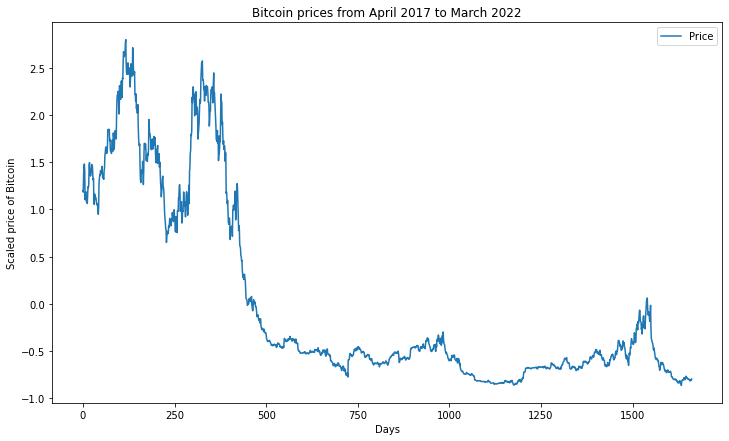

In [ ]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
#plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from April 2017 to March 2022')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

In [ ]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 7)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 7, 1)
y_train size: (1018, 1)
X_test size: (637, 7, 1)
y_test size: (637, 1)


In [ ]:
#we now define the network
#Hyperparameters used in the network
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 200 

import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])



#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

Instructions for updating:
non-resource variables are not supported in the long term


[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_383:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_447:0' shape=(1, 1) dtype=float32>]

In [ ]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    

Epoch 0/200  Current loss: 0.1139531210064888
Epoch 30/200  Current loss: 0.02770365960896015
Epoch 60/200  Current loss: 0.010734126903116703
Epoch 90/200  Current loss: 0.008252499625086784
Epoch 120/200  Current loss: 0.0071736788377165794
Epoch 150/200  Current loss: 0.006581791210919619
Epoch 180/200  Current loss: 0.006169014144688845


In [ ]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [ ]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)


In [ ]:
tests_new = []
for i in range(len(tests)):
      for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [ ]:

test_results = []
for i in range(1264):
      if i >= 1019:
        test_results.append(tests_new[i-1019])
      else:
        test_results.append(None)
        

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


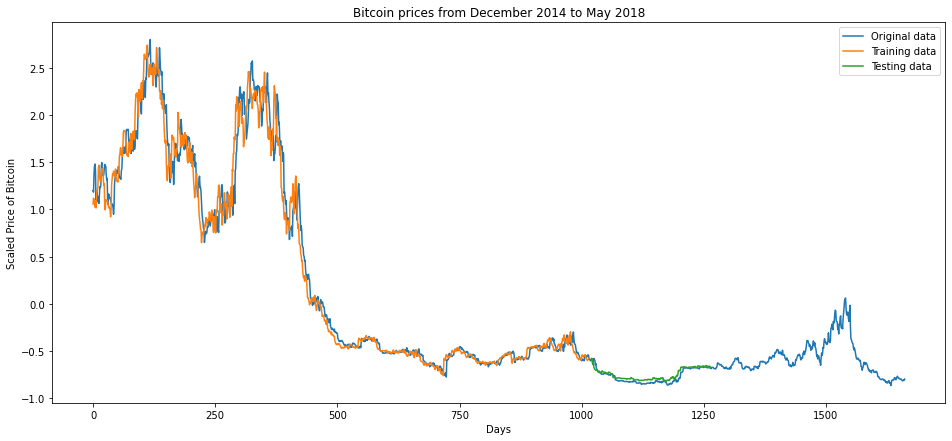

In [ ]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from April 2017 to March 2022')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

## **Actual Test (Aug 2017- march 2022)**

In [ ]:
!pip install tensorflow==2.5

In [ ]:
import json
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=1835')
#hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = pd.read_csv(('btc.csv'))
hist = hist.set_index('Date')
#hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'Close'

In [ ]:
print(hist)

                    Open         High          Low        Close        Volume  \
Date                                                                            
Aug-16-2017   4376.63000   4484.70000   4243.71000   4349.10000  2.291049e+09   
Aug-17-2017   4331.69000   4370.13000   4015.40000   4128.86000  2.659080e+09   
Aug-18-2017   4160.62000   4243.26000   3970.55000   4202.15000  3.055205e+09   
Aug-19-2017   4193.70000   4196.29000   4069.88000   4108.93000  2.491605e+09   
Aug-20-2017   4087.66000   4109.14000   3988.60000   4001.47000  2.392425e+09   
...                  ...          ...          ...          ...           ...   
Feb-28-2022  43182.00540  44788.07490  42934.44260  44359.87120  9.293590e+10   
Mar-01-2022  44404.91790  45173.58090  43387.87690  43938.47684  7.774557e+10   
Mar-02-2022  43901.74614  44035.45904  41862.51810  42450.88343  6.651299e+10   
Mar-03-2022  42465.00663  42498.51626  38732.82492  39120.04240  7.318878e+10   
Mar-04-2022  39144.65309  39

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)


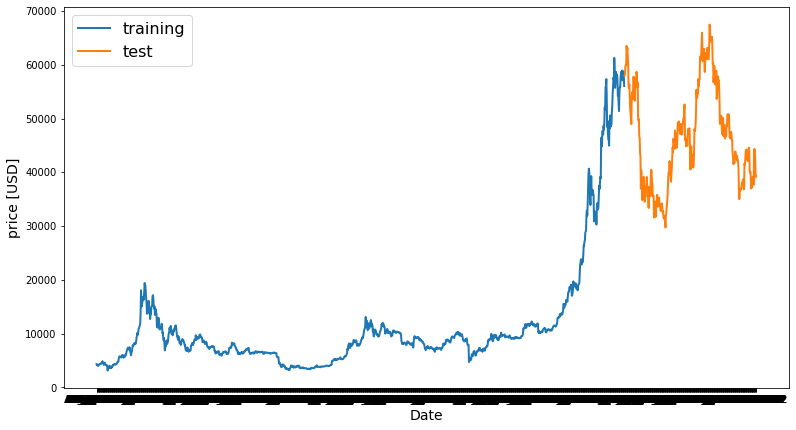

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
train[target_col]

Date
Aug-16-2017     4349.10000
Aug-17-2017     4128.86000
Aug-18-2017     4202.15000
Aug-19-2017     4108.93000
Aug-20-2017     4001.47000
                  ...     
Apr-02-2021    57139.13796
Apr-03-2021    58215.19000
Apr-04-2021    58777.73936
Apr-05-2021    58093.23833
Apr-06-2021    56073.47156
Name: Close, Length: 1330, dtype: float64

In [ ]:
test[target_col]

Date
Apr-07-2021    58019.88000
Apr-08-2021    58159.44000
Apr-09-2021    59747.43680
Apr-10-2021    60018.28649
Apr-11-2021    59940.53000
                  ...     
Feb-28-2022    44359.87120
Mar-01-2022    43938.47684
Mar-02-2022    42450.88343
Mar-03-2022    39120.04240
Mar-04-2022    39409.21247
Name: Close, Length: 332, dtype: float64

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 18
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/50
74/74 [==============================] - 3s 15ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 2/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 3/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 4/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 5/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 6/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 8/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 9/50
74/74 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 11/50
74/74

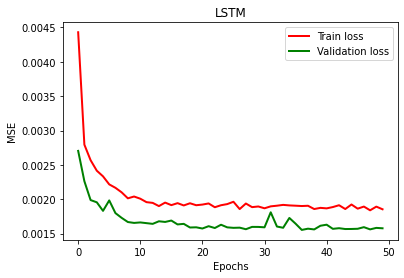

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc="upper right")
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.029164573783931103

In [ ]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(y_test, preds)
MSE

0.0015776160135074517

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7748407232312262

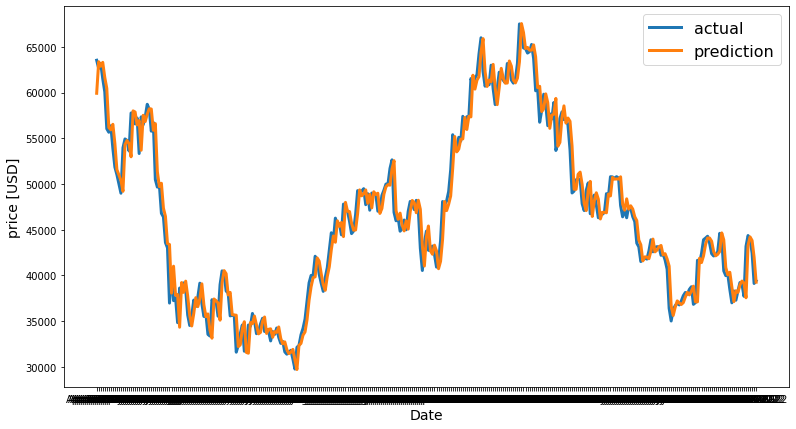

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

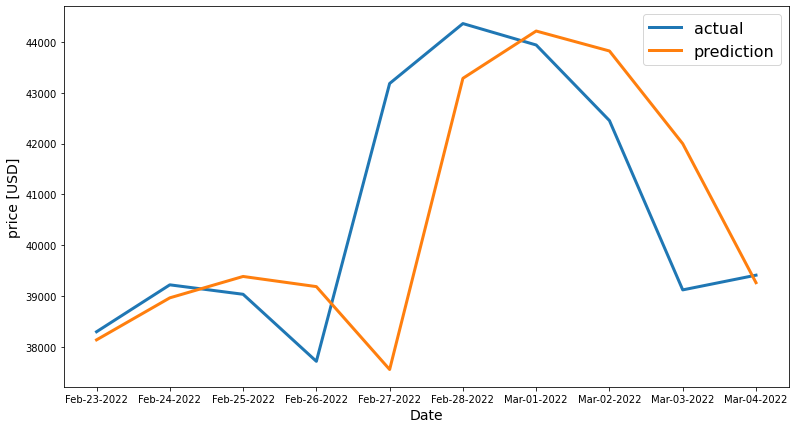

In [ ]:
n_points = 10

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

## **Actual Model-1000 days**

In [ ]:
import json
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=1835')
#hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = pd.read_csv(('1000.csv'))
hist = hist.set_index('Date')
#hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'Close'

In [ ]:
print(hist)

                    Open         High           Low         Close  \
Date                                                                
Jul-11-2019  11385.97704  11850.91675  11187.860640  11776.082440   
Jul-12-2019  11776.78111  11805.29147  10946.069000  11397.161430   
Jul-13-2019  11394.84070  11458.26953  10288.853120  10288.853120   
Jul-14-2019  10227.41750  11029.55392  10041.932580  10885.588450   
Jul-15-2019  10857.07941  10996.63559   9448.365403   9499.558669   
...                  ...          ...           ...           ...   
Apr-02-2022  45793.52919  47331.95470  45556.131180  46430.696710   
Apr-03-2022  46429.49649  46853.48820  45201.068710  46605.602970   
Apr-04-2022  46598.16005  47143.74184  45573.537410  45573.537410   
Apr-05-2022  45479.96945  45479.96945  43138.519470  43138.519470   
Apr-06-2022  43154.77454  43855.36370  42814.948200  43480.174720   

                   Volume    Market Cap  
Date                                     
Jul-11-2019   2643

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)


In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
train[target_col]

Date
Jul-11-2019    11776.082440
Jul-12-2019    11397.161430
Jul-13-2019    10288.853120
Jul-14-2019    10885.588450
Jul-15-2019     9499.558669
                   ...     
Sep-14-2021    48092.970300
Sep-15-2021    47816.250400
Sep-16-2021    47197.551800
Sep-17-2021    48210.777400
Sep-18-2021    47201.501800
Name: Close, Length: 801, dtype: float64

In [ ]:
test[target_col]

Date
Sep-19-2021    42966.01010
Sep-20-2021    40538.43440
Sep-21-2021    43579.97298
Sep-22-2021    44844.22800
Sep-23-2021    42748.03530
                  ...     
Apr-02-2022    46430.69671
Apr-03-2022    46605.60297
Apr-04-2022    45573.53741
Apr-05-2022    43138.51947
Apr-06-2022    43480.17472
Name: Close, Length: 200, dtype: float64

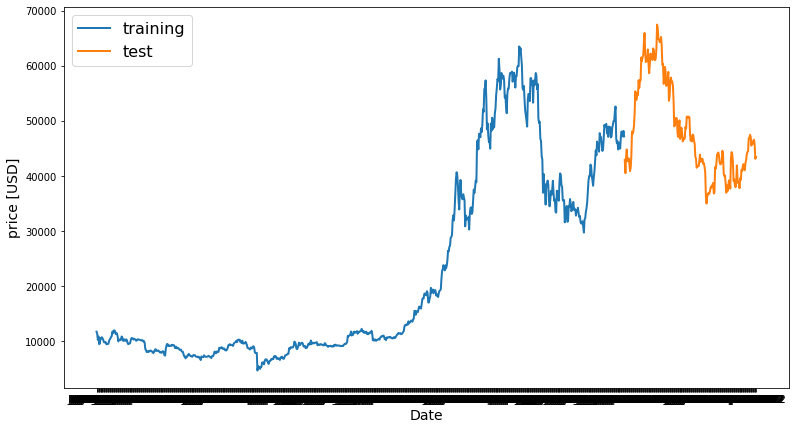

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')


In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 18
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/50
45/45 [==============================] - 5s 34ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 2/50
45/45 [==============================] - 1s 23ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/50
45/45 [==============================] - 1s 16ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/50
45/45 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/50
45/45 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/50
45/45 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/50
45/45 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/50
45/45 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/50
45/45 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 10/50
45/45 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 11/

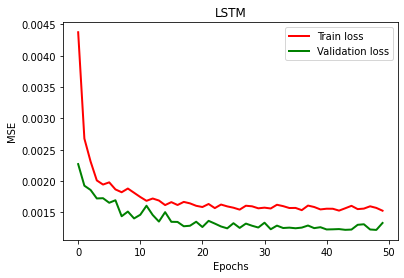

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc="upper right")
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.02681475290264817

In [ ]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(y_test, preds)
MSE

0.0013316671265725059

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7590480788006934

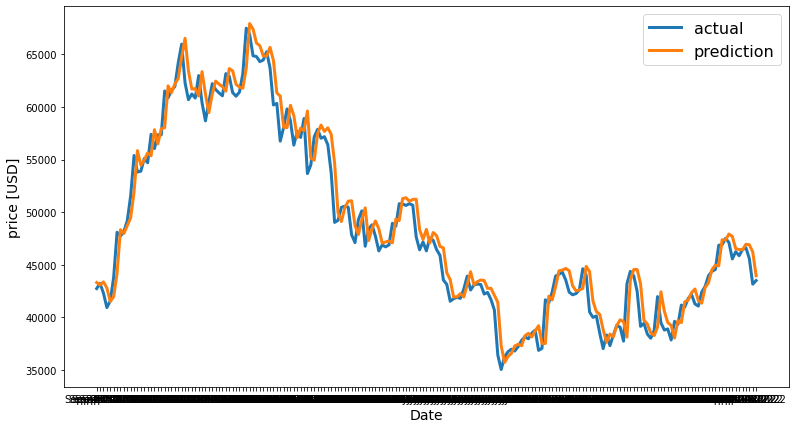

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

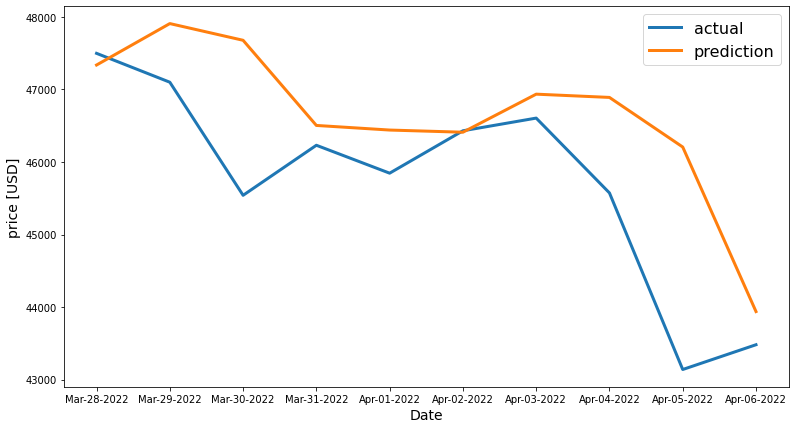

In [ ]:
n_points = 10

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

## **500 days**

In [ ]:
import json
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=1835')
#hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = pd.read_csv(('500.csv'))
hist = hist.set_index('Date')
#hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'Close'

In [ ]:
print(hist)

                    Open         High          Low        Close        Volume  \
Date                                                                            
Nov-22-2020  18400.41621  18750.75866  18032.68421  18374.45258   56013957456   
Nov-23-2020  18383.26053  19412.49430  18042.08297  19121.51141   65582487334   
Nov-24-2020  19151.45251  19461.56864  18547.97903  18770.20210   66020446070   
Nov-25-2020  18736.04887  18911.14877  16290.95338  17072.81034   76574550474   
Nov-26-2020  17157.38411  17419.95808  16487.30151  17076.84202   66090936295   
...                  ...          ...          ...          ...           ...   
Apr-02-2022  45793.52919  47331.95470  45556.13118  46430.69671   53182050972   
Apr-03-2022  46429.49649  46853.48820  45201.06871  46605.60297   75797947520   
Apr-04-2022  46598.16005  47143.74184  45573.53741  45573.53741  107956835470   
Apr-05-2022  45479.96945  45479.96945  43138.51947  43138.51947   82230669555   
Apr-06-2022  43154.77454  43

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)


In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
train[target_col]

Date
Nov-22-2020    18374.45258
Nov-23-2020    19121.51141
Nov-24-2020    18770.20210
Nov-25-2020    17072.81034
Nov-26-2020    17076.84202
                  ...     
Dec-23-2021    50771.92770
Dec-24-2021    50629.98124
Dec-25-2021    50799.97886
Dec-26-2021    50650.17144
Dec-27-2021    47637.88840
Name: Close, Length: 401, dtype: float64

In [ ]:
test[target_col]

Date
Dec-28-2021    46408.30267
Dec-29-2021    47161.00920
Dec-30-2021    46304.94959
Dec-31-2021    47544.49940
Jan-01-2022    47313.63220
                  ...     
Apr-02-2022    46430.69671
Apr-03-2022    46605.60297
Apr-04-2022    45573.53741
Apr-05-2022    43138.51947
Apr-06-2022    43480.17472
Name: Close, Length: 100, dtype: float64

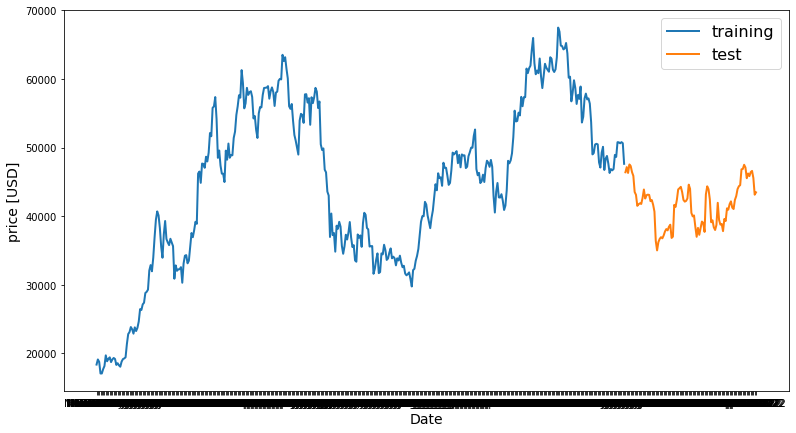

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')


In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 18
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/50
22/22 [==============================] - 3s 38ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 2/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 3/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 4/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 5/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 6/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 7/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 8/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 9/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 10/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 11/50
22/22

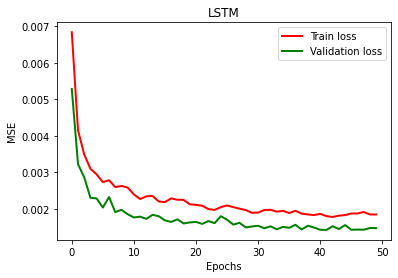

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc="upper right")
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.027055129145020784

In [ ]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(y_test, preds)
MSE

0.0014715641317745907

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7501658830344251

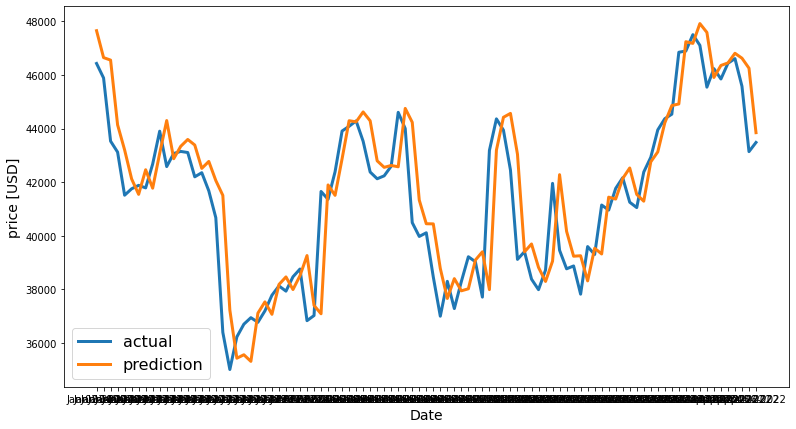

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

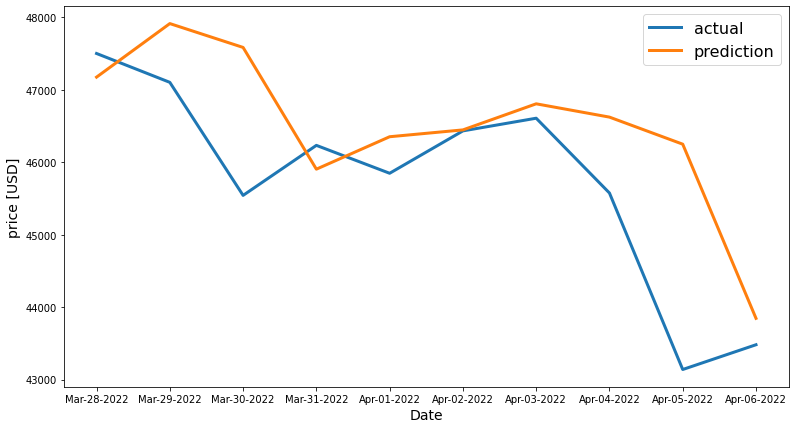

In [ ]:
n_points = 10

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

## **300 days**

In [ ]:
import json
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=1835')
#hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = pd.read_csv(('300.csv'))
hist = hist.set_index('Date')
#hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'Close'

In [ ]:
print(hist)

                    Open         High          Low        Close        Volume  \
Date                                                                            
Jun-10-2021  36646.86000  37565.99000  36061.67000  37200.35000   65346487154   
Jun-11-2021  37328.20000  37328.20000  34749.95700  35538.30000   63889684892   
Jun-12-2021  35506.77000  39356.80282  34842.27000  38990.00000   57312107534   
Jun-13-2021  39106.54000  40920.03000  38785.32000  40499.97000   76608277490   
Jun-14-2021  40527.71000  41267.29017  39656.74025  40204.51000   72036187548   
...                  ...          ...          ...          ...           ...   
Apr-02-2022  45793.52919  47331.95470  45556.13118  46430.69671   53182050972   
Apr-03-2022  46429.49649  46853.48820  45201.06871  46605.60297   75797947520   
Apr-04-2022  46598.16005  47143.74184  45573.53741  45573.53741  107956835470   
Apr-05-2022  45479.96945  45479.96945  43138.51947  43138.51947   82230669555   
Apr-06-2022  43154.77454  43

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)


In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
train[target_col]

Date
Jun-10-2021    37200.35000
Jun-11-2021    35538.30000
Jun-12-2021    38990.00000
Jun-13-2021    40499.97000
Jun-14-2021    40204.51000
                  ...     
Feb-01-2022    36835.90150
Feb-02-2022    37027.78000
Feb-03-2022    41653.56036
Feb-04-2022    41360.05380
Feb-05-2022    42388.07234
Name: Close, Length: 241, dtype: float64

In [ ]:
test[target_col]

Date
Feb-06-2022    43905.99798
Feb-07-2022    44082.39258
Feb-08-2022    44283.91420
Feb-09-2022    43524.37792
Feb-10-2022    42377.65270
Feb-11-2022    42126.35110
Feb-12-2022    42235.51360
Feb-13-2022    42594.94190
Feb-14-2022    44602.53150
Feb-15-2022    43997.71160
Feb-16-2022    40491.04120
Feb-17-2022    39976.23595
Feb-18-2022    40112.55953
Feb-19-2022    38464.85280
Feb-20-2022    37003.15356
Feb-21-2022    38302.84390
Feb-22-2022    37287.48634
Feb-23-2022    38296.16593
Feb-24-2022    39219.47676
Feb-25-2022    39033.53530
Feb-26-2022    37714.48389
Feb-27-2022    43181.14370
Feb-28-2022    44359.87120
Mar-01-2022    43938.47684
Mar-02-2022    42450.88343
Mar-03-2022    39120.04240
Mar-04-2022    39409.21247
Mar-05-2022    38385.18525
Mar-06-2022    37991.87947
Mar-07-2022    38724.82009
Mar-08-2022    41955.06532
Mar-09-2022    39461.35102
Mar-10-2022    38770.04591
Mar-11-2022    38875.98605
Mar-12-2022    37824.35153
Mar-13-2022    39599.02437
Mar-14-2022    39302.01

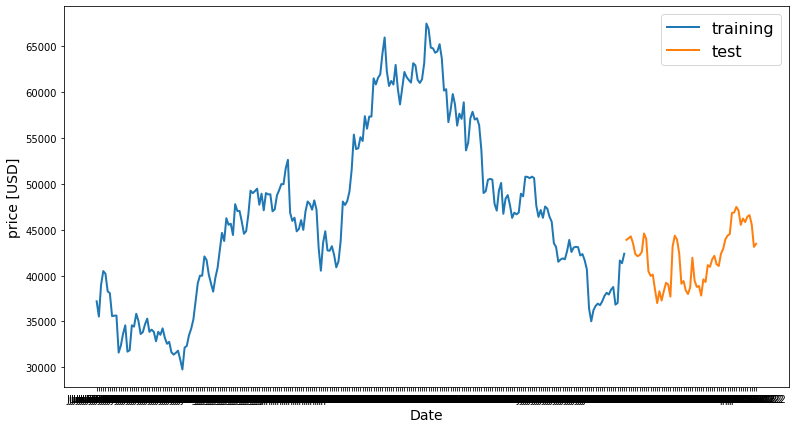

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')


In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 18
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/50
14/14 [==============================] - 5s 65ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 2/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 3/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 4/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 5/50
14/14 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 6/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 7/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/50
14/14 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 9/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 10/50
14/14 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 11/5

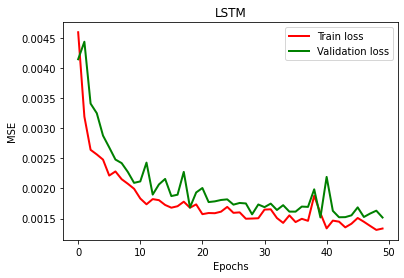

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc="upper right")
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.026812168891186174

In [ ]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(y_test, preds)
MSE

0.0015173066591496161

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.707245069285004

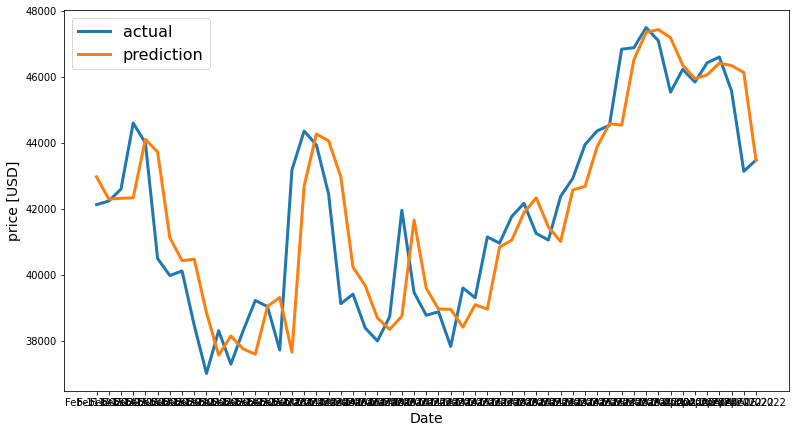

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

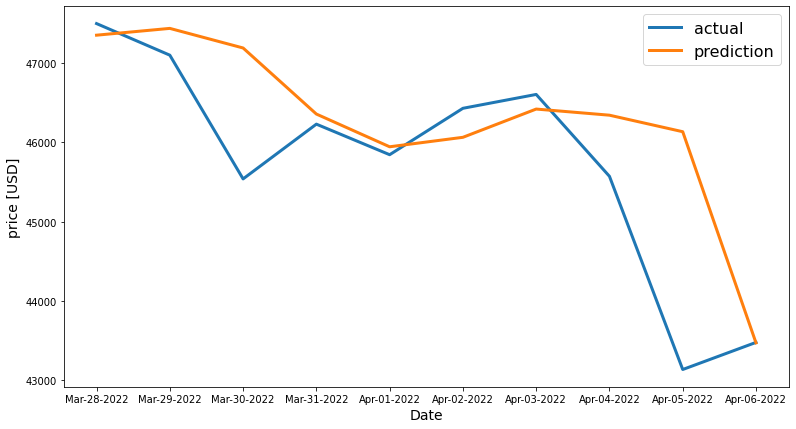

In [ ]:
n_points = 10

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

## **100 Days**

In [ ]:
import json
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=1835')
#hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = pd.read_csv(('100.csv'))
hist = hist.set_index('Date')
#hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'Close'

In [ ]:
print(hist)

                    Open         High          Low        Close        Volume  \
Date                                                                            
Dec-27-2021  50667.98834  50667.98834  47411.71724  47637.88840   59398212508   
Dec-28-2021  47547.86550  48112.02147  46272.66298  46408.30267   88269733931   
Dec-29-2021  46430.48122  47876.49184  46077.72228  47161.00920  122924810126   
Dec-30-2021  47139.35900  48505.99970  45712.56659  46304.94959   78100267492   
Dec-31-2021  46198.20378  47840.31079  46198.20378  47544.49940   99413619769   
...                  ...          ...          ...          ...           ...   
Apr-02-2022  45793.52919  47331.95470  45556.13118  46430.69671   53182050972   
Apr-03-2022  46429.49649  46853.48820  45201.06871  46605.60297   75797947520   
Apr-04-2022  46598.16005  47143.74184  45573.53741  45573.53741  107956835470   
Apr-05-2022  45479.96945  45479.96945  43138.51947  43138.51947   82230669555   
Apr-06-2022  43154.77454  43

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)


In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
test[target_col]

Date
Mar-18-2022    42166.22954
Mar-19-2022    41252.05199
Mar-20-2022    41051.83346
Mar-21-2022    42376.74422
Mar-22-2022    42925.97798
Mar-23-2022    43948.89113
Mar-24-2022    44365.18255
Mar-25-2022    44533.21742
Mar-26-2022    46842.71955
Mar-27-2022    46888.22115
Mar-28-2022    47498.66565
Mar-29-2022    47100.45937
Mar-30-2022    45540.82639
Mar-31-2022    46231.00476
Apr-01-2022    45845.95756
Apr-02-2022    46430.69671
Apr-03-2022    46605.60297
Apr-04-2022    45573.53741
Apr-05-2022    43138.51947
Apr-06-2022    43480.17472
Name: Close, dtype: float64

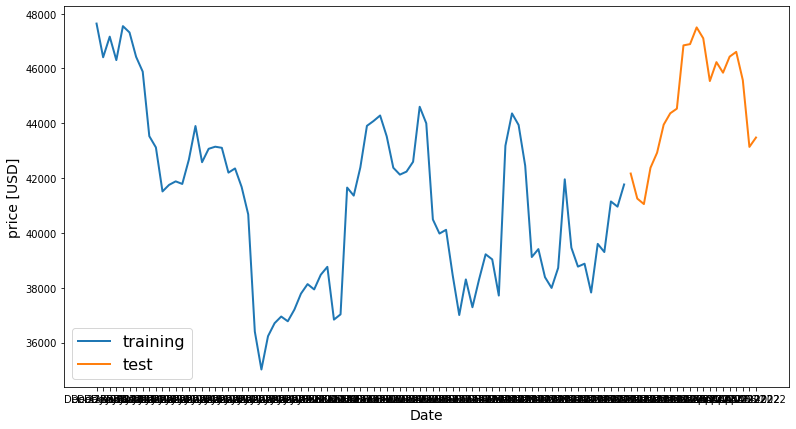

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')


In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 18
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/50
5/5 [==============================] - 3s 136ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 4/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 5/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 7/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 9/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 10/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 11/50
5/5 [===========

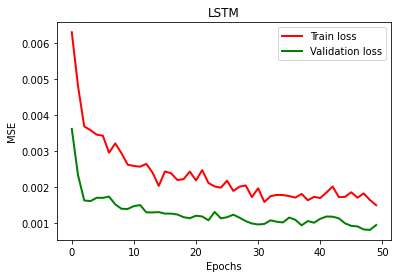

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc="upper right")
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.024613325947385627

In [ ]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(y_test, preds)
MSE

0.0009399666659883429

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6793264738771518

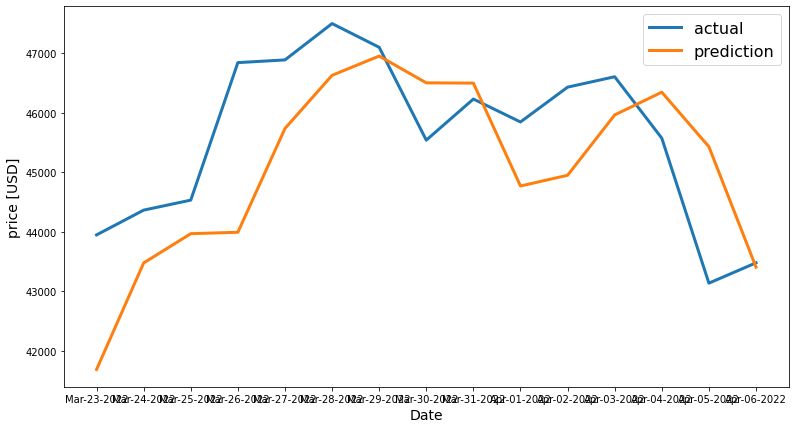

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

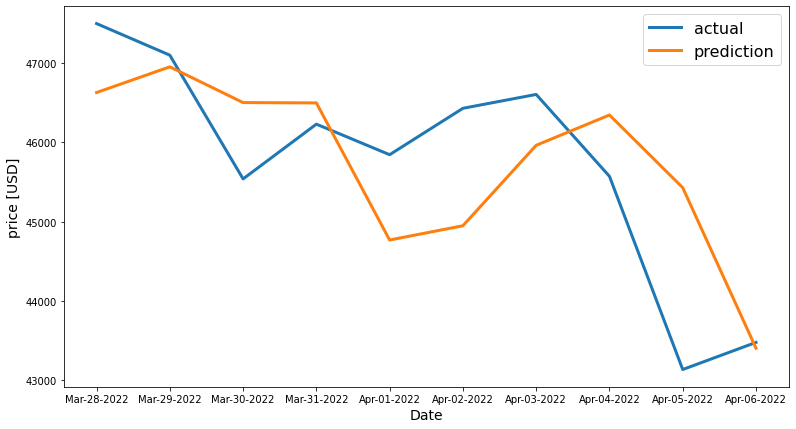

In [ ]:
n_points = 10

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

## **60 Days**

In [ ]:
import json
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=1835')
#hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = pd.read_csv(('60.csv'))
hist = hist.set_index('Date')
#hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'Close'

In [ ]:
print(hist)

                    Open         High          Low        Close        Volume  \
Date                                                                            
Jan-07-2022  41543.16010  42298.47950  40642.19860  41752.93000   85660416754   
Jan-08-2022  41686.15811  42687.53151  41375.02630  41880.90095   70389962012   
Jan-09-2022  41841.86352  42217.65400  39782.07448  41786.21840   95449311303   
Jan-10-2022  41835.66220  43049.98235  41284.89140  42674.29720   74616303445   
Jan-11-2022  42710.84750  44168.12790  42470.15004  43900.02700   54479088242   
Jan-12-2022  43888.84400  44290.04229  42334.35469  42580.33030   50948501191   
Jan-13-2022  42549.95900  43387.73825  41808.15116  43068.72658   62549530396   
Jan-14-2022  43061.11596  43728.01290  42642.32323  43145.30763   62347797020   
Jan-15-2022  43099.97907  43421.95670  42609.70490  43104.67713   56378730624   
Jan-16-2022  43072.25578  43120.07920  41583.01487  42199.00911   69711029248   
Jan-17-2022  42229.52722  42

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)


In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
train[target_col]

Date
Jan-07-2022    41752.93000
Jan-08-2022    41880.90095
Jan-09-2022    41786.21840
Jan-10-2022    42674.29720
Jan-11-2022    43900.02700
Jan-12-2022    42580.33030
Jan-13-2022    43068.72658
Jan-14-2022    43145.30763
Jan-15-2022    43104.67713
Jan-16-2022    42199.00911
Jan-17-2022    42352.13590
Jan-18-2022    41676.49878
Jan-19-2022    40673.94412
Jan-20-2022    36400.66800
Jan-21-2022    35015.93463
Jan-22-2022    36231.14260
Jan-23-2022    36705.91790
Jan-24-2022    36948.63103
Jan-25-2022    36775.52950
Jan-26-2022    37201.84235
Jan-27-2022    37784.72290
Jan-28-2022    38131.82360
Jan-29-2022    37937.33900
Jan-30-2022    38472.00624
Jan-31-2022    38761.96830
Feb-01-2022    36835.90150
Feb-02-2022    37027.78000
Feb-03-2022    41653.56036
Feb-04-2022    41360.05380
Feb-05-2022    42388.07234
Feb-06-2022    43905.99798
Feb-07-2022    44082.39258
Feb-08-2022    44283.91420
Feb-09-2022    43524.37792
Feb-10-2022    42377.65270
Feb-11-2022    42126.35110
Feb-12-2022    42235.51

In [ ]:
test[target_col]

Date
Feb-24-2022    39219.47676
Feb-25-2022    39033.53530
Feb-26-2022    37714.48389
Feb-27-2022    43181.14370
Feb-28-2022    44359.87120
Mar-01-2022    43938.47684
Mar-02-2022    42450.88343
Mar-03-2022    39120.04240
Mar-04-2022    39409.21247
Mar-05-2022    38385.18525
Mar-06-2022    37991.87947
Mar-07-2022    38724.82009
Name: Close, dtype: float64

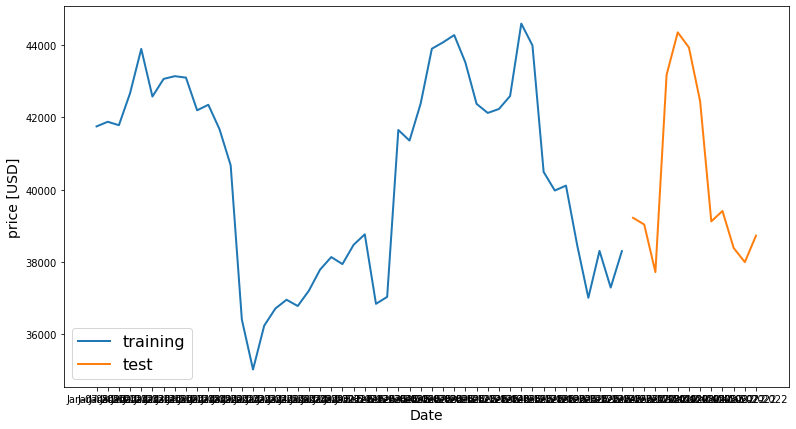

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')


In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=2, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=3, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [ ]:
np.random.seed(42)
window_len = 2
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 5
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/50
10/10 [==============================] - 2s 55ms/step - loss: 0.0028 - val_loss: 0.0059
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0058
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0057
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0056
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 6/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 8/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 10/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 11/50
10/10 

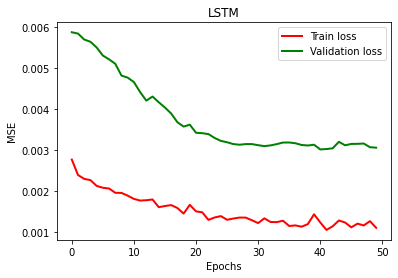

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc="upper right")
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.03413464658001488

In [ ]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(y_test, preds)
MSE

0.003055485996307638

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.5288175163665858

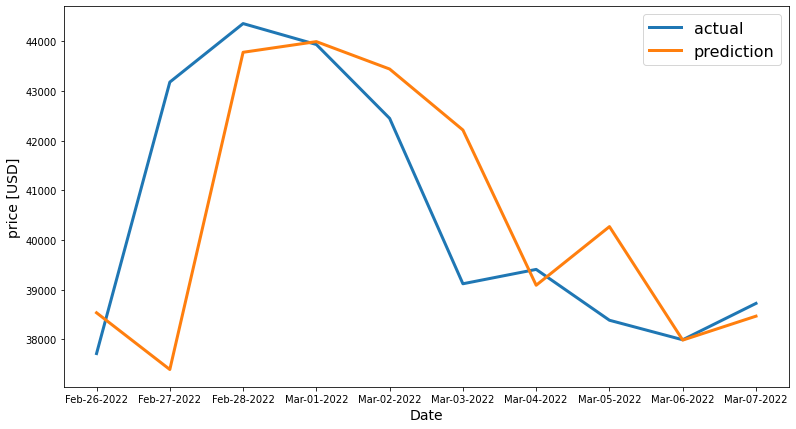

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

## **50 Days**

In [ ]:
import json
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=1835')
#hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = pd.read_csv(('50.csv'))
hist = hist.set_index('Date')
#hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'Close'

In [ ]:
print(hist)

                    Open         High          Low        Close        Volume  \
Date                                                                            
Feb-15-2022  44522.95890  44522.95890  43367.64420  43997.71160   51244306560   
Feb-16-2022  43874.06590  44101.50510  40214.02227  40491.04120   59257593216   
Feb-17-2022  40528.12510  40924.09716  39629.33836  39976.23595   67854684189   
Feb-18-2022  39991.16762  40427.21165  39652.00960  40112.55953   50941849785   
Feb-19-2022  40096.00167  40100.04290  38077.04080  38464.85280   39952153991   
Feb-20-2022  38362.69454  39402.35077  36922.02850  37003.15356   57203595477   
Feb-21-2022  37060.00781  38337.82510  36444.81827  38302.84390   81464065636   
Feb-22-2022  38227.77740  39158.34010  37088.33878  37287.48634  108954655659   
Feb-23-2022  37216.40439  39132.78270  34408.52933  38296.16593  130682462236   
Feb-24-2022  38329.38683  39616.95160  38054.57113  39219.47676   85942038343   
Feb-25-2022  39226.46287  39

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)


In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
train[target_col]

Date
Feb-15-2022    43997.71160
Feb-16-2022    40491.04120
Feb-17-2022    39976.23595
Feb-18-2022    40112.55953
Feb-19-2022    38464.85280
Feb-20-2022    37003.15356
Feb-21-2022    38302.84390
Feb-22-2022    37287.48634
Feb-23-2022    38296.16593
Feb-24-2022    39219.47676
Feb-25-2022    39033.53530
Feb-26-2022    37714.48389
Feb-27-2022    43181.14370
Feb-28-2022    44359.87120
Mar-01-2022    43938.47684
Mar-02-2022    42450.88343
Mar-03-2022    39120.04240
Mar-04-2022    39409.21247
Mar-05-2022    38385.18525
Mar-06-2022    37991.87947
Mar-07-2022    38724.82009
Mar-08-2022    41955.06532
Mar-09-2022    39461.35102
Mar-10-2022    38770.04591
Mar-11-2022    38875.98605
Mar-12-2022    37824.35153
Mar-13-2022    39599.02437
Mar-14-2022    39302.01679
Mar-15-2022    41147.27989
Mar-16-2022    40958.22516
Mar-17-2022    41767.09817
Mar-18-2022    42166.22954
Mar-19-2022    41252.05199
Mar-20-2022    41051.83346
Mar-21-2022    42376.74422
Mar-22-2022    42925.97798
Mar-23-2022    43948.89

In [ ]:
test[target_col]

Date
Mar-28-2022    47498.66565
Mar-29-2022    47100.45937
Mar-30-2022    45540.82639
Mar-31-2022    46231.00476
Apr-01-2022    45845.95756
Apr-02-2022    46430.69671
Apr-03-2022    46605.60297
Apr-04-2022    45573.53741
Apr-05-2022    43138.51947
Apr-06-2022    43480.17472
Name: Close, dtype: float64

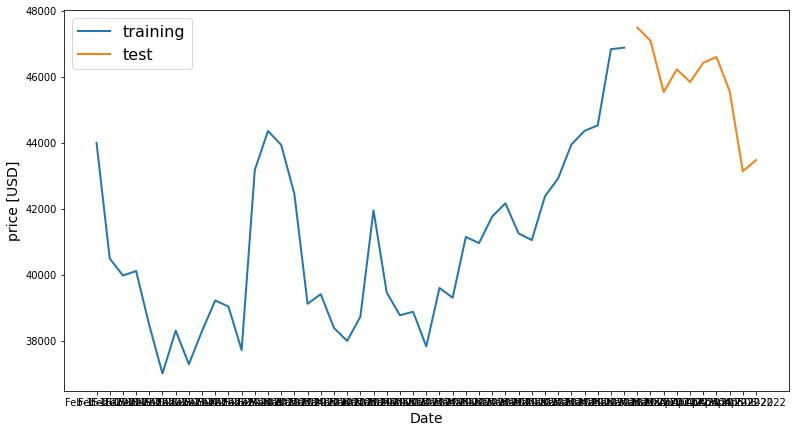

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')


In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=2, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=3, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [ ]:
np.random.seed(42)
window_len = 2
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 5
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/50
8/8 [==============================] - 2s 67ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 10/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 11/50
8/8 [=====================

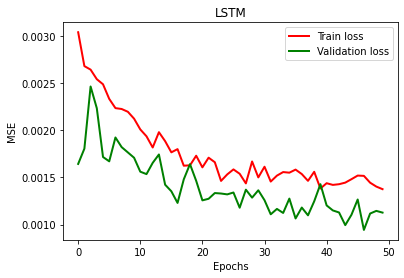

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc="upper right")
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.021427907891912013

In [ ]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(y_test, preds)
MSE

0.001127000313197425

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

-0.34308519197578047

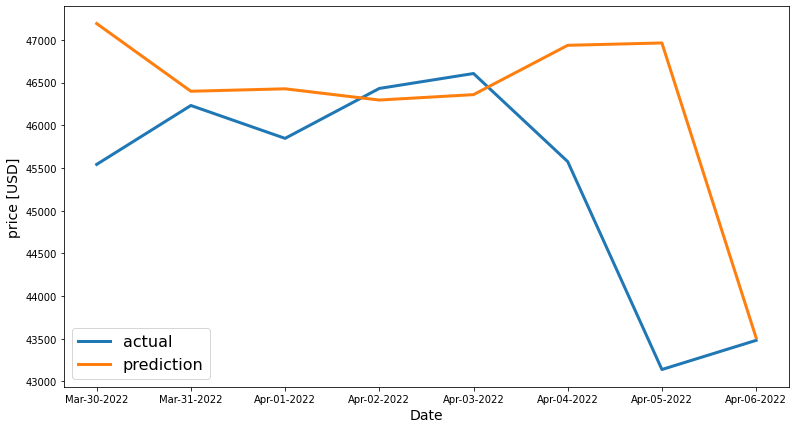

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

## **30 Days**

In [ ]:
import json
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=1835')
#hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = pd.read_csv(('30.csv'))
hist = hist.set_index('Date')
#hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'Close'

In [ ]:
print(hist)

                    Open         High          Low        Close        Volume  \
Date                                                                            
Mar-07-2022  38021.16231  39333.71310  38021.16231  38724.82009   87695148501   
Mar-08-2022  38741.22398  42508.69721  38680.08468  41955.06532   81739633849   
Mar-09-2022  41950.43524  42002.18786  38770.03143  39461.35102  117700388864   
Mar-10-2022  39427.62799  40118.98829  38291.84880  38770.04591   73106728690   
Mar-11-2022  38729.04139  39321.40250  38722.92220  38875.98605   56650400299   
Mar-12-2022  38803.98637  39220.94410  37670.38924  37824.35153   33924499228   
Mar-13-2022  37784.66665  39808.38173  37590.88150  39599.02437   47001002610   
Mar-14-2022  39669.01847  39805.39961  38230.94190  39302.01679   54149954759   
Mar-15-2022  39301.17956  41538.60060  38964.63682  41147.27989   74235084060   
Mar-16-2022  41115.36918  41306.80617  40600.02900  40958.22516   68916952832   
Mar-17-2022  40912.96043  42

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)


In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(35, 15))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
train[target_col]

Date
Mar-07-2022    38724.82009
Mar-08-2022    41955.06532
Mar-09-2022    39461.35102
Mar-10-2022    38770.04591
Mar-11-2022    38875.98605
Mar-12-2022    37824.35153
Mar-13-2022    39599.02437
Mar-14-2022    39302.01679
Mar-15-2022    41147.27989
Mar-16-2022    40958.22516
Mar-17-2022    41767.09817
Mar-18-2022    42166.22954
Mar-19-2022    41252.05199
Mar-20-2022    41051.83346
Mar-21-2022    42376.74422
Mar-22-2022    42925.97798
Mar-23-2022    43948.89113
Mar-24-2022    44365.18255
Mar-25-2022    44533.21742
Mar-26-2022    46842.71955
Mar-27-2022    46888.22115
Mar-28-2022    47498.66565
Mar-29-2022    47100.45937
Mar-30-2022    45540.82639
Mar-31-2022    46231.00476
Name: Close, dtype: float64

In [ ]:
test[target_col]

Date
Apr-01-2022    45845.95756
Apr-02-2022    46430.69671
Apr-03-2022    46605.60297
Apr-04-2022    45573.53741
Apr-05-2022    43138.51947
Apr-06-2022    43480.17472
Name: Close, dtype: float64

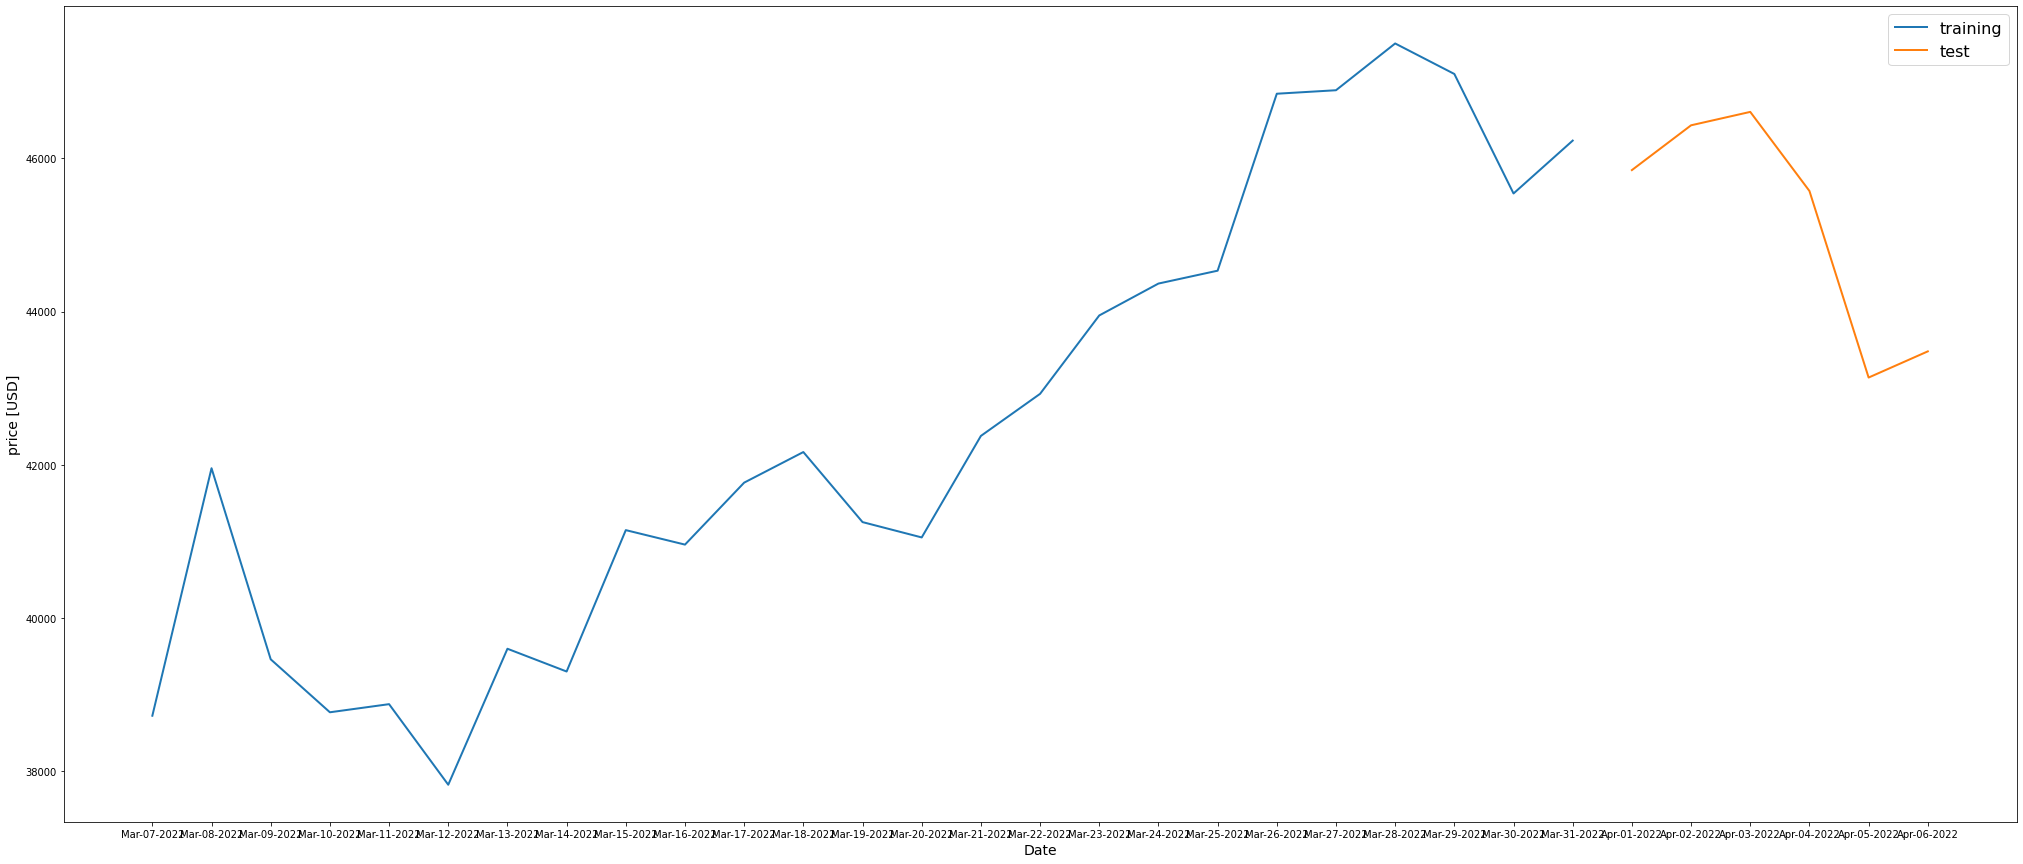

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')


In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=2, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=3, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [ ]:
np.random.seed(42)
window_len = 2
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 5
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               42800     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/50
5/5 [==============================] - 5s 150ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 9.3624e-04 - val_loss: 0.0024
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 9.4472e-04 - val_loss: 0.0027
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 9.9688e-04 - val_loss: 0.0027
Epoch 8/50
5/5 [==============================] - 0s 13ms/step - loss: 8.7586e-04 - val_loss: 0.0025
Epoch 9/50
5/5 [==============================] - 0s 12ms/step - loss: 8.7188e-04 - val_loss: 0.0022
Epoch 10/50
5/5 [==============================] - 0s 11ms/step - loss: 8.6666e-04 - val_loss: 0.0021
Epoc

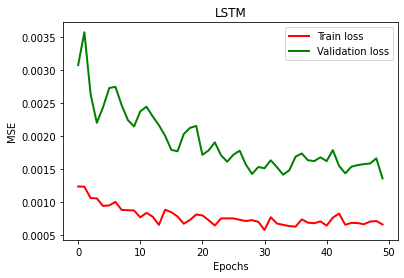

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc="upper right")
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.026705146315560507

In [ ]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(y_test, preds)
MSE

0.001353567337336789

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

-0.19647842919632774

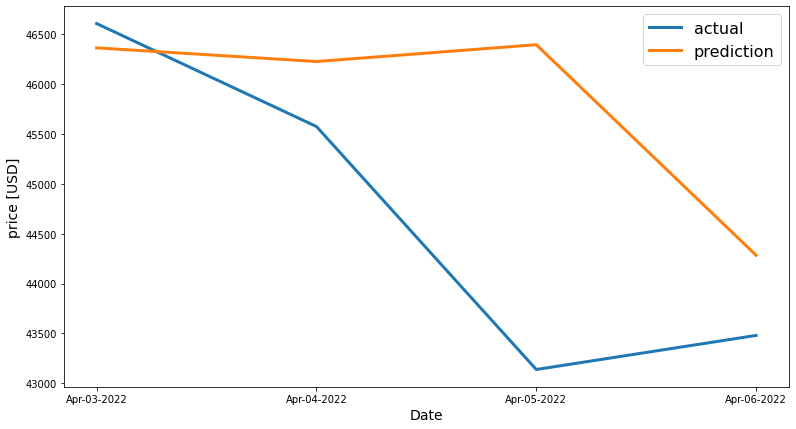

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)